# Data Creation

In this stage, we convert the connectome and the lineage tree into NetworkX objects, and store them for further processing as graphml files.

In [44]:
# !pip3 install networkx numpy pandas git+https://github.com/aplbrain/mossDB tqdm matplotlib seaborn

In [69]:
import networkx as nx
from mossdb.client import MossDBClient
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import json
import io
from pathlib import Path

In [79]:
class Config:
        
    def get_lineage_graph():
        lin = nx.json_graph.tree_graph(json.load(Config.LINEAGE_JSON_PATH.open()))
        # Relabel the nodes with the `name` attribute:
        return nx.relabel_nodes(lin, {n: a['name'] for n, a in lin.nodes(data=True)})
    
    def get_connectome():
        # fh = io.BytesIO(MossDBClient("http://mossdb").get_file(Config.CONNECTOME_GRAPHML_MOSS_URI))
        # return nx.read_graphml(fh)
        return nx.read_graphml(Config.CONNECTOME_GRAPHML_PATH)
    
    def distance_shortest_path(lineage: nx.DiGraph, source: str, target: str):
        """
        Return the shortest path distance between two nodes in a lineage graph.

        Arguments:
            lineage (nx.DiGraph): The target graph
            source (str): The source node
            target (str): The target node
        
        Returns:
            int: The shortest path distance between the source and target nodes

        """
        try:
            return nx.shortest_path_length(nx.Graph(lineage), source, target)
        except:
            return np.nan

    def distance_common_successors(connectome: nx.DiGraph, source: str, target: str):
        """
        Return the number of common successors between two nodes in a connectome graph.

        Arguments:
            connectome (nx.DiGraph): The target graph
            source (str): The source node
            target (str): The target node
        
        Returns:
            int: The number of common successors between the source and target nodes

        """
        try:
            return len(set(connectome.successors(source)).intersection(connectome.successors(target)))
        except Exception as e:
            print(e)
            return np.nan

    LINEAGE_JSON_PATH = Path("./data/bhatla-lineage.json")
    CONNECTOME_GRAPHML_MOSS_URI = "file://graphs/witvliet2020/witvliet_2020_8_node_attributes"
    CONNECTOME_GRAPHML_PATH = Path("./data/witvliet2021-Dataset8.graphml")

    FOLD_CONNECTOME = True

    LINEAGE_DISTANCE_METRIC = distance_shortest_path
    CONNECTOME_DISTANCE_METRIC = distance_common_successors

In [80]:
def fold_connectome(connectome: nx.DiGraph, prefer_side: str = "R") -> nx.DiGraph:
    """
    Merges all neurons in the connectome that have left (-L) and right (-R)
    counterparts into a single node.

    Arguments:
        connectome (nx.DiGraph): The connectome to fold.
        prefer_side (str: "R"): The side to prefer when folding.
    
    Returns:
        nx.DiGraph: The connectome with the neurons merged.
        
    """
    # Copy the connectome:
    connectome = connectome.copy()

    # Nodes either end in -L or -R:
    # We can collapse all *L into a *R.
    # If the user prefers "L", then collapse all *R into *L.

    non_preferred_side = "L" if prefer_side == "R" else "R"
    for node in connectome.nodes():
        if node.endswith(prefer_side) and f"{node[:-1]}{non_preferred_side}" in connectome:
            # Collapse the two nodes:
            connectome = nx.contracted_nodes(
                connectome, 
                node, f"{node[:-1]}{non_preferred_side}"
            )
    return connectome


In [81]:
LINEAGE = Config.get_lineage_graph()
ORIGINAL_CONNECTOME = Config.get_connectome()
CONNECTOME = fold_connectome(ORIGINAL_CONNECTOME) if Config.FOLD_CONNECTOME else ORIGINAL_CONNECTOME

## Compute Distances

This is a slow process.

In [83]:
# Compute distances between all nodes in the lineage.

lineage_distances = {
    (u, v): Config.LINEAGE_DISTANCE_METRIC(LINEAGE, u, v)
    for u in LINEAGE.nodes
    for v in LINEAGE.nodes
    if u.upper() in CONNECTOME and v.upper() in CONNECTOME
}

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [84]:
# Compute overlap similarities between all nodes in the connectome.

connectome_similarities = {
    (u, v): Config.CONNECTOME_DISTANCE_METRIC(CONNECTOME, u, v)
    for u in CONNECTOME.nodes
    for v in CONNECTOME.nodes
}

Exception ignored in: <function tqdm.__del__ at 0x7f2696ea9dc0>
Traceback (most recent call last):
  File "/home/apluser/.pyenv/versions/3.9.6/envs/motifs/lib/python3.9/site-packages/tqdm/std.py", line 1152, in __del__
    self.close()
  File "/home/apluser/.pyenv/versions/3.9.6/envs/motifs/lib/python3.9/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


In [90]:
_all_valid_neuron_pairs = [k for k in connectome_distances.keys() if k in lineage_distances]

neuron_pairs = pd.DataFrame({
    "u": [k[0] for k in _all_valid_neuron_pairs],
    "u_type": [CONNECTOME.nodes[k[0]]['typ'] for k in _all_valid_neuron_pairs],
    "v": [k[1] for k in _all_valid_neuron_pairs],
    "v_type": [CONNECTOME.nodes[k[1]]['typ'] for k in _all_valid_neuron_pairs],
    "lineage_distance": [lineage_distances[k] for k in _all_valid_neuron_pairs],
    "connectome_similarity": [connectome_similarities[k] for k in _all_valid_neuron_pairs],
})

neuron_pairs['uv_same_type'] = neuron_pairs.u_type == neuron_pairs.v_type

## Visualization, Analysis, and Paper Figures

<AxesSubplot:xlabel='lineage_distance', ylabel='connectome_similarity'>

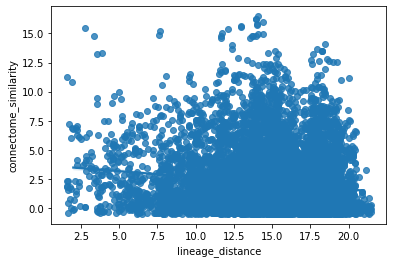

In [86]:
sns.regplot(
    x="lineage_distance",
    y="connectome_similarity",
    data=neuron_pairs[neuron_pairs.u != neuron_pairs.v],
    x_jitter=0.5,
    y_jitter=0.5,
)

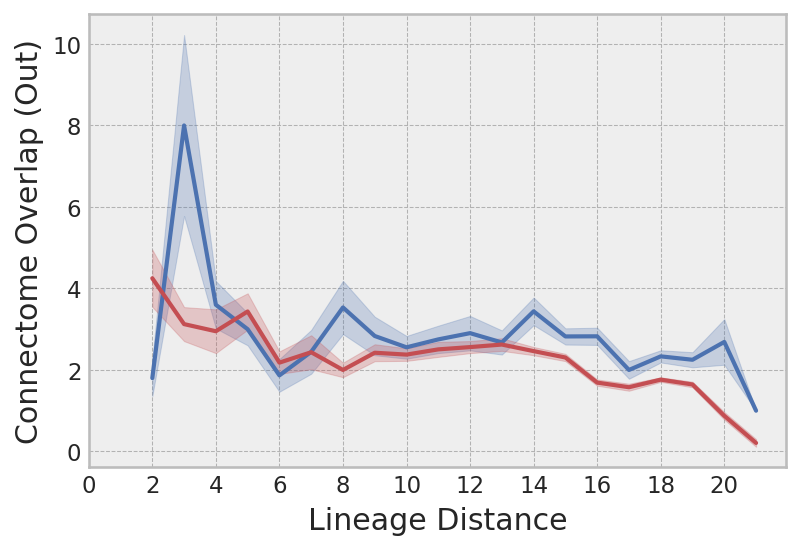

In [120]:
with plt.style.context("bmh"):
    plt.figure(figsize=(6, 4), dpi=150)
    _filtered_groupby = neuron_pairs[
        neuron_pairs.uv_same_type &
        (neuron_pairs.u != neuron_pairs.v)
    ].groupby("lineage_distance")

    sns.lineplot(
        x=_filtered_groupby.groups.keys(), 
        y=_filtered_groupby.mean().connectome_similarity,
        color='b'
    )
    plt.fill_between(
        _filtered_groupby.groups.keys(), 
        _filtered_groupby.mean().connectome_similarity - _filtered_groupby.sem().connectome_similarity,
        _filtered_groupby.mean().connectome_similarity + _filtered_groupby.sem().connectome_similarity,
        alpha=0.25, color='b'
    )


    _filtered_groupby = neuron_pairs[
        ~neuron_pairs.uv_same_type &
        (neuron_pairs.u != neuron_pairs.v)
    ].groupby("lineage_distance")

    sns.lineplot(
        x=_filtered_groupby.groups.keys(), 
        y=_filtered_groupby.mean().connectome_similarity,
        color='r'
    )
    plt.fill_between(
        _filtered_groupby.groups.keys(), 
        _filtered_groupby.mean().connectome_similarity - _filtered_groupby.sem().connectome_similarity,
        _filtered_groupby.mean().connectome_similarity + _filtered_groupby.sem().connectome_similarity,
        alpha=0.25, color='r'
    )

    plt.xlabel("Lineage Distance")
    plt.ylabel("Connectome Overlap (Out)")
    plt.xticks(
        range(0, int(max(_filtered_groupby.groups.keys())), 2),
        range(0, int(max(_filtered_groupby.groups.keys())), 2)
    )
